In [175]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import calinski_harabasz_score

import matplotlib.pyplot as plt

In [56]:
from sklearn.preprocessing import MinMaxScaler

from bokeh.plotting import figure, output_file, show, output_notebook
from bokeh.models import ColorBar, ColumnDataSource, Panel, Tabs
from bokeh.transform import factor_cmap, linear_cmap
from bokeh.palettes import brewer, d3, viridis

In [114]:
def make_plot(data):
    data = data.copy()
    cluster = data['cluster'].unique()
    sc = MinMaxScaler((10, 50))
    data['scaled_value'] = sc.fit_transform(data['netPatrimony'].values.reshape(-1, 1))
    
    tooltips = [
        ('Fund', '@fundName'),
        ('AAFM', '@aafmCategory'),
        ('Cluster', '@cluster'),
        ('AUM', '@netPatrimony'),
        ('AnnRet', '@ann_return'),
        ('AnnStDev', '@ann_stdev'),
        ('Anomaly', '@dist_anomaly')
    ]
    p = figure(plot_width=800, plot_height=800, tooltips=tooltips, title=f'Chilean Mutual Funds', x_axis_label='Component 1',
              y_axis_label='Component 2')
    source = ColumnDataSource(data=data)
    cmap = linear_cmap('cluster', palette=viridis(len(cluster)), low=cluster.min(), high=cluster.max())
    p.circle('x_coord', 'y_coord', source=source, size='scaled_value', color=cmap, alpha=0.7)
    cmap_anomaly = linear_cmap('dist_anomaly', palette=[None, '#ff0000'], low=0, high=1)
    p.cross('x_coord', 'y_coord', source=source, size='scaled_value', color=cmap_anomaly)
    return p

In [4]:
data = pd.read_csv('../data/FundDataWithMonthlyReturnsTSNEandScored.csv')
data.head()

,fundRUN,fundName,fundSeries,aafmCategory,svsCategory,svsCategoryId,currency,fundRUNSeries,userCategory,2015-01-31,...,2021-01-31,x_coord,y_coord,netPatrimony,providedFlow,rescuedFlow,ann_return,ann_stdev,pca_anomaly,dist_anomaly
0,8812-9,A. CHILE CALIFICADO,D,Inversionistas Calificados Accionario Nacional,FM DIRIGIDO A INVERSIONISTAS CALIFICADOS,8.0,P,8812-9D,"Domestic Bond, < 365",0.0,...,0.007059,49.043568,31.558483,2.057013e+08,1.397999e+06,1.624005e+06,0.054833,18.275449,0,0
1,8289-9,ACCIONES CHILE,APV,Accionario Nacional Large CAP,FM DE INVERSION EN INSTRUMENTOS DE CAPITALIZACION,5.0,P,8289-9APV,Domestic Equity,0.0,...,0.021519,48.599960,29.826206,9.093564e+07,5.398776e+04,2.750340e+04,-2.699522,18.133874,0,0
2,8076-4,ACCIONES CHILENAS,APV,Accionario Nacional Large CAP,FM DE INVERSION EN INSTRUMENTOS DE CAPITALIZACION,5.0,P,8076-4APV,Domestic Equity,0.0,...,0.024364,46.495964,24.676537,5.264871e+09,1.849870e+06,3.550476e+06,-0.228134,18.098522,0,0
3,9254-1,ACCIONES EUROPA,ALTO,Accionario Europa Desarrollado,FM DE INVERSION EN INSTRUMENTOS DE CAPITALIZACION,5.0,P,9254-1ALTO,International Equity,0.0,...,0.019622,-46.026010,3.815157,1.038922e+09,6.401805e+06,1.216734e+06,0.444373,20.991343,0,0
4,8247-3,ACCIONES LATAM,A,Accionario America Latina,FM DE INVERSION EN INSTRUMENTOS DE CAPITALIZACION,5.0,P,8247-3A,International Equity,0.0,...,-0.017005,-2.541078,-44.528522,2.430189e+09,1.271666e+07,8.701922e+06,0.701076,23.831971,0,0


In [14]:
print(f"Number of current categories: {data['aafmCategory'].nunique()}")

Number of current categories: 31


In [119]:
cols = data.columns[9:-10]  # only return data
# cols = cols.append(data.columns[-10:-8])  # adds tSNE coordinates
cols = cols.append(data.columns[-5:-3])  # adds annual return and stdev
df = data[cols]

If the ground truth labels are not known, the Calinski-Harabasz index (sklearn.metrics.calinski_harabasz_score) - also known as the Variance Ratio Criterion - can be used to evaluate the model, where a higher Calinski-Harabasz score relates to a model with better defined clusters.

The index is the ratio of the sum of between-clusters dispersion and of within-cluster dispersion for all clusters (where dispersion is defined as the sum of distances squared):

In [179]:
score = []
thresh = np.linspace(0.1, 1.1, 11)
for t in thresh:
    pl = Pipeline(
        steps=[
            ('scaler', StandardScaler()),
            ('cluster', AgglomerativeClustering(n_clusters=None, affinity='cosine', linkage='average', distance_threshold=t))
        ]
    )
    pl.fit(df)
    score.append(calinski_harabasz_score(df, pl.named_steps['cluster'].labels_))

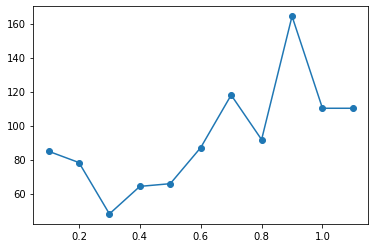

In [180]:
plt.plot(thresh, score, 'o-')
plt.show()

In [181]:
pl = Pipeline(
        steps=[
            ('scaler', StandardScaler()),
            ('cluster', AgglomerativeClustering(n_clusters=None, affinity='cosine', linkage='average', distance_threshold=0.9))
#             ('cluster', AgglomerativeClustering(n_clusters=None, distance_threshold=20))
        ]
    )
pl.fit(df)
n_clusters = pl.named_steps['cluster'].n_clusters_
print(f'Number of clusters found: {n_clusters}')
data['cluster'] = pl.named_steps['cluster'].labels_

Number of clusters found: 5


In [182]:
output_notebook()
show(make_plot(data))

Loading BokehJS ...

In [172]:
pl = Pipeline(
        steps=[
            ('scaler', StandardScaler()),
#             ('cluster', AgglomerativeClustering(n_clusters=None, affinity='cosine', linkage='average', distance_threshold=0.7))
            ('cluster', AgglomerativeClustering(n_clusters=None, distance_threshold=20))
        ]
    )
pl.fit(df)
n_clusters = pl.named_steps['cluster'].n_clusters_
print(f'Number of clusters found: {n_clusters}')
data['cluster'] = pl.named_steps['cluster'].labels_

Number of clusters found: 19


In [173]:
output_notebook()
show(make_plot(data))

Loading BokehJS ...